# Image Captioning Project
## Using PyTorch and Transformers with Real Dataset

**Important:** After running the installation cell (Cell 1), you may need to **restart the kernel** for the packages to be properly loaded. Go to: Kernel → Restart Kernel, then run all cells again.



In [ ]:
# Install required libraries with proper version constraints
%pip install "numpy<2" "torch>=2.0" torchvision transformers pillow requests nltk datasets accelerate ipywidgets jupyter ultralytics opencv-python -q


In [ ]:
pip install "openai>=1.40.0,<2.0.0" -q

## 1.5. Vocabulary and CNN-RNN Model Components


In [ ]:
# Import required modules for Vocabulary
from collections import Counter
from nltk.tokenize import word_tokenize

class Vocabulary:
    """Vocabulary class for word-to-index mapping"""
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.word_freq = Counter()

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        """Build vocabulary from list of sentences"""
        for sentence in sentence_list:
            words = self.tokenize(sentence)
            self.word_freq.update(words)

        # Add words that meet frequency threshold
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                if word not in self.stoi:
                    self.stoi[word] = len(self.itos)
                    self.itos[len(self.itos)] = word

    def numericalize(self, text):
        """Convert text to numerical tokens"""
        tokenized_text = self.tokenize(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

    def textify(self, numerical_list):
        """Convert numerical tokens back to text"""
        return [self.itos[idx] for idx in numerical_list if idx not in [0, 1, 2, 3]]

print("Vocabulary class ready!")


Vocabulary class ready!


In [ ]:
# Import required modules for CNN-RNN model components
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Attention(nn.Module):
    """Attention mechanism for image-caption alignment"""
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)
        self.A = nn.Linear(attention_dim, 1)

    def forward(self, features, decoder_hidden):
        u_hs = self.U(features)
        w_h = self.W(decoder_hidden).unsqueeze(1)
        att = self.A(torch.tanh(u_hs + w_h))
        alpha = F.softmax(att.squeeze(2), dim=1)
        attention_weighted_encoding = (features * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha


class CNNEncoder(nn.Module):
    """CNN Encoder supporting multiple torchvision backbones"""
    def __init__(self, encoder_name='resnet50', encoded_image_size=14, fine_tune=True):
        super().__init__()
        self.encoder_name = encoder_name.lower()
        self.encoder_dim = None
        self.backbone = self._build_backbone(self.encoder_name)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune(fine_tune)

    def _build_backbone(self, encoder_name):
        if encoder_name == 'resnet50':
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.encoder_dim = 2048
            return nn.Sequential(*list(backbone.children())[:-2])
        elif encoder_name == 'efficientnet_b3':
            backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
            self.encoder_dim = backbone.classifier[1].in_features
            return backbone.features
        elif encoder_name == 'convnext_small':
            backbone = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
            self.encoder_dim = 768
            return backbone.features
        else:
            # Default to resnet50
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.encoder_dim = 2048
            return nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, images):
        out = self.backbone(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)
        batch_size = out.size(0)
        return out.view(batch_size, -1, self.encoder_dim)

    def fine_tune(self, fine_tune=True):
        for param in self.backbone.parameters():
            param.requires_grad = False
        if fine_tune:
            for layer in list(self.backbone.children())[-3:]:
                for param in layer.parameters():
                    param.requires_grad = True


class RNNDecoder(nn.Module):
    """RNN Decoder with Attention supporting LSTM or GRU cells"""
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048,
                 dropout=0.5, decoder_type='lstm'):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout_p = dropout
        self.decoder_type = decoder_type.lower()

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=dropout)
        rnn_input_dim = embed_dim + encoder_dim
        if self.decoder_type == 'gru':
            self.decode_cell = nn.GRUCell(rnn_input_dim, decoder_dim, bias=True)
        else:
            self.decode_cell = nn.LSTMCell(rnn_input_dim, decoder_dim, bias=True)
            self.decoder_type = 'lstm'
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        if self.decoder_type == 'lstm':
            c = self.init_c(mean_encoder_out)
        else:
            c = torch.zeros_like(h)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        embeddings = self.embedding(encoded_captions)
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caption_lengths - 1).tolist()
        max_decode_len = max(decode_lengths)
        vocab_size = self.vocab_size
        predictions = torch.zeros(batch_size, max_decode_len, vocab_size, device=encoder_out.device)
        alphas = torch.zeros(batch_size, max_decode_len, num_pixels, device=encoder_out.device)

        for t in range(max_decode_len):
            batch_size_t = sum(l > t for l in decode_lengths)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = torch.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            rnn_input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            if self.decoder_type == 'lstm':
                h_t, c_t = self.decode_cell(rnn_input, (h[:batch_size_t], c[:batch_size_t]))
                h = h.clone()
                c = c.clone()
                h[:batch_size_t], c[:batch_size_t] = h_t, c_t
            else:
                h_t = self.decode_cell(rnn_input, h[:batch_size_t])
                h = h.clone()
                h[:batch_size_t] = h_t
            preds = self.fc(self.dropout(h[:batch_size_t]))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind


class ImageCaptionModel(nn.Module):
    """Complete Image Captioning Model with configurable encoder/decoder"""
    def __init__(self, vocab_size, embed_dim=256, decoder_dim=512, attention_dim=256,
                 encoder_name='resnet50', dropout=0.5, fine_tune_encoder=True, decoder_type='lstm'):
        super().__init__()
        self.encoder = CNNEncoder(encoder_name=encoder_name, fine_tune=fine_tune_encoder)
        self.decoder = RNNDecoder(attention_dim, embed_dim, decoder_dim, vocab_size,
                                  encoder_dim=self.encoder.encoder_dim, dropout=dropout,
                                  decoder_type=decoder_type)

    def forward(self, images, encoded_captions, caption_lengths):
        encoder_out = self.encoder(images)
        return self.decoder(encoder_out, encoded_captions, caption_lengths)

print("CNN-RNN model components ready!")


CNN-RNN model components ready!


In [ ]:
# Import YOLO and check availability
try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except ImportError:
    print("Warning: YOLO not available. Install with: pip install ultralytics")
    YOLO_AVAILABLE = False
    YOLO = None

class YOLOObjectDetector:
    """YOLO-based object detector for enhancing caption context"""
    def __init__(self, model_name='yolov8n.pt'):
        self.model = None
        if YOLO_AVAILABLE:
            try:
                self.model = YOLO(model_name)
                print(f"YOLO model {model_name} loaded successfully!")
            except Exception as e:
                print(f"Warning: Could not load YOLO model: {e}")
                self.model = None

    def detect_objects(self, image):
        """Detect objects in image and return list of object names"""
        if self.model is None:
            return []

        try:
            results = self.model(image, verbose=False)
            objects = []
            for result in results:
                if result.boxes is not None:
                    for box in result.boxes:
                        class_id = int(box.cls[0])
                        class_name = self.model.names[class_id]
                        confidence = float(box.conf[0])
                        if confidence > 0.5:  # Only high confidence detections
                            objects.append(class_name)
            return list(set(objects))  # Return unique objects
        except Exception as e:
            print(f"Error in object detection: {e}")
            return []

# Initialize YOLO detector
yolo_detector = YOLOObjectDetector()
print("YOLO integration ready!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLO model yolov8n.pt loaded successfully!
YOLO integration ready!


## 1.6. CNN-RNN Dataset for Hugging Face Flickr8k


In [ ]:
# Import required modules for CNNRNNDataset
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

class CNNRNNDataset(Dataset):
    """Dataset for CNN-RNN model using Hugging Face Flickr8k dataset"""

    def __init__(self, hf_dataset, vocab, max_length=50, transform=None, split='train', use_yolo=False):
        """
        Args:
            hf_dataset: Hugging Face dataset (DatasetDict or Dataset)
            vocab: Vocabulary object
            max_length: Maximum caption length
            transform: Optional image transforms
            split: Dataset split to use ('train', 'validation', 'test')
            use_yolo: Whether to use YOLO for object detection enhancement
        """
        self.vocab = vocab
        self.max_length = max_length
        self.use_yolo = use_yolo

        # Default transform for CNN-RNN
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        # Extract the split from DatasetDict or use the dataset directly
        if hasattr(hf_dataset, 'keys'):
            if split in hf_dataset:
                self.dataset = hf_dataset[split]
            else:
                raise ValueError(f"Split '{split}' not found in dataset. Available splits: {list(hf_dataset.keys())}")
        else:
            self.dataset = hf_dataset

        print(f"Loaded {len(self.dataset)} examples from {split} split for CNN-RNN")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        # Get image (already a PIL Image from Hugging Face)
        image = example['image']
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        image = image.convert('RGB')

        # Get caption - Flickr8k has caption_0, caption_1, etc.
        caption = example.get('caption_0', example.get('caption', 'a photo'))

        # Use YOLO to enhance context if enabled
        if self.use_yolo:
            try:
                if 'yolo_detector' in globals() and yolo_detector.model is not None:
                    objects = yolo_detector.detect_objects(image)
                    if objects:
                        caption = f"{caption} {' '.join(objects[:2])}"
            except:
                pass

        # Apply transform
        if self.transform:
            image = self.transform(image)

        # Numericalize caption
        caption_tokens = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]

        # Pad or truncate
        if len(caption_tokens) > self.max_length:
            caption_tokens = caption_tokens[:self.max_length]
        else:
            caption_tokens = caption_tokens + [self.vocab.stoi["<PAD>"]] * (self.max_length - len(caption_tokens))

        # Get image ID
        image_id = example.get('image_id', example.get('id', f'img_{idx}'))

        return {
            'image': image,
            'caption': torch.tensor(caption_tokens, dtype=torch.long),
            'caption_length': torch.tensor([len([t for t in caption_tokens if t != self.vocab.stoi["<PAD>"]])], dtype=torch.long),
            'caption_text': caption,
            'image_id': str(image_id)
        }


def cnn_rnn_collate_fn(batch):
    """Custom collate function for CNN-RNN dataset"""
    images = torch.stack([item['image'] for item in batch])
    captions = torch.stack([item['caption'] for item in batch])
    caption_lengths = torch.stack([item['caption_length'] for item in batch])
    caption_texts = [item['caption_text'] for item in batch]
    image_ids = [item.get('image_id', '') for item in batch]

    return {
        'images': images,
        'captions': captions,
        'caption_lengths': caption_lengths,
        'caption_texts': caption_texts,
        'image_ids': image_ids
    }

print("CNN-RNN dataset class ready!")


CNN-RNN dataset class ready!


## 1.7. CNN-RNN Caption Generation Functions


In [ ]:
# Import required modules for caption generation
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

DEFAULT_BEAM_SIZE = 5

def generate_caption_beam_search(model, image, vocab, device, beam_size=None, max_length=50, repetition_penalty=1.5):
    """Generate caption using beam search for CNN-RNN model with repetition penalty"""
    if beam_size is None:
        beam_size = DEFAULT_BEAM_SIZE
    model.eval()

    # Encode image
    encoder_out = model.encoder(image)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    encoder_dim = encoder_out.size(2)

    # Initialize decoder
    h, c = model.decoder.init_hidden_state(encoder_out)

    # Expand for beam search
    encoder_out = encoder_out.expand(beam_size, num_pixels, encoder_dim)
    h = h.expand(beam_size, h.size(1))
    c = c.expand(beam_size, c.size(1))

    # Start with <SOS> token
    k_prev_words = torch.LongTensor([[vocab.stoi["<SOS>"]]] * beam_size).to(device)
    seqs = k_prev_words
    top_k_scores = torch.zeros(beam_size, 1).to(device)

    complete_seqs = []
    complete_seqs_scores = []

    step = 1
    while True:
        embeddings = model.decoder.embedding(k_prev_words).squeeze(1)
        attention_weighted_encoding, alpha = model.decoder.attention(encoder_out, h)
        gate = torch.sigmoid(model.decoder.f_beta(h))
        attention_weighted_encoding = gate * attention_weighted_encoding
        rnn_input = torch.cat([embeddings, attention_weighted_encoding], dim=1)
        if model.decoder.decoder_type == 'lstm':
            h, c = model.decoder.decode_cell(rnn_input, (h, c))
        else:
            h = model.decoder.decode_cell(rnn_input, h)
        scores = model.decoder.fc(model.decoder.dropout(h))
        scores = F.log_softmax(scores, dim=1)

        # Apply repetition penalty: penalize words that have appeared in the sequence
        if step > 1:
            for i in range(beam_size):
                # Get unique words in the sequence (excluding SOS, EOS, PAD, UNK)
                unique_words = set()
                for word_idx in seqs[i].cpu().tolist():
                    if word_idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"], vocab.stoi["<UNK>"]]:
                        unique_words.add(word_idx)

                # Penalize repeated words
                for word_idx in unique_words:
                    if word_idx < scores.size(1):
                        # Reduce the score for words that have already appeared
                        scores[i, word_idx] = scores[i, word_idx] / repetition_penalty

        scores = top_k_scores.expand_as(scores) + scores

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(beam_size, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(beam_size, 0, True, True)

        prev_word_inds = top_k_words // vocab.__len__()
        next_word_inds = top_k_words % vocab.__len__()

        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != vocab.stoi["<EOS>"]]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
            beam_size -= len(complete_inds)

        if beam_size == 0:
            break

        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > max_length:
            break
        step += 1

    if len(complete_seqs_scores) > 0:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
    else:
        seq = seqs[0].tolist()

    # Convert to text and remove consecutive duplicates
    words = vocab.textify(seq)
    # Remove consecutive duplicate words
    cleaned_words = []
    prev_word = None
    for word in words:
        if word != prev_word:
            cleaned_words.append(word)
        prev_word = word

    return ' '.join(cleaned_words)


def generate_cnn_rnn_caption(image_path_or_url, cnn_rnn_model, vocab, device, use_yolo=False, beam_size=None):
    """Generate caption using CNN-RNN model"""
    try:
        beam_size = beam_size or DEFAULT_BEAM_SIZE
        # Load image
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url, timeout=10)
            image_pil = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image_pil = Image.open(image_path_or_url).convert('RGB')

        # Apply transforms
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        # Use YOLO to detect objects if enabled
        detected_objects = []
        if use_yolo and 'yolo_detector' in globals() and yolo_detector.model is not None:
            try:
                detected_objects = yolo_detector.detect_objects(image_pil)
            except:
                pass

        # Generate caption
        cnn_rnn_model.eval()
        with torch.no_grad():
            caption = generate_caption_beam_search(
                cnn_rnn_model, image_tensor, vocab, device, beam_size=beam_size, max_length=50
            )

        # Enhance caption with YOLO objects if detected
        if detected_objects and use_yolo:
            objects_str = ", ".join(detected_objects[:3])
            caption = f"{caption} (contains: {objects_str})"

        return image_pil, caption
    except Exception as e:
        import traceback
        return None, f"Error: {str(e)}\n{traceback.format_exc()}"


def generate_transformer_caption_from_pil(image_pil, transformer_model, processor, device):
    """Generate caption using transformer model from PIL image"""
    try:
        inputs = processor(images=image_pil, return_tensors="pt").to(device)
        transformer_model.eval()
        with torch.no_grad():
            generated_ids = transformer_model.generate(
                **inputs,
                max_length=50,
                num_beams=3,
                early_stopping=True
            )
        caption = processor.decode(generated_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        return f"(transformer error: {e})"

print("CNN-RNN caption generation functions ready!")


CNN-RNN caption generation functions ready!


## 1.8. Image-based Recommendation Function


In [ ]:
# Import required modules for recommendations
from nltk.tokenize import word_tokenize

# Global variables for image-based recommendations
_last_uploaded_image = None
_last_cnn_caption = None
_last_transformer_caption = None
_last_yolo_objects = None

def get_image_based_recommendations(base_text, image_pil=None, cnn_caption=None, transformer_caption=None, yolo_objects=None, vocab=None):
    """Get word recommendations based on the uploaded image and generated captions."""
    words = set()
    base_tokens = set(word_tokenize(base_text.lower())) if base_text else set()

    # 1. Add words from generated captions (most relevant)
    for cap in [cnn_caption, transformer_caption]:
        if cap:
            for w in word_tokenize(cap.lower()):
                if w.isalpha() and len(w) > 2 and w not in base_tokens:
                    words.add(w)

    # 2. Add YOLO-detected objects (image-specific context)
    if yolo_objects:
        for obj in yolo_objects:
            obj_words = word_tokenize(obj.lower())
            for w in obj_words:
                if w.isalpha() and len(w) > 2 and w not in base_tokens:
                    words.add(w)

    # 3. Add common caption words from vocabulary (if available)
    if vocab is not None:
        common_caption_words = ['man', 'woman', 'person', 'people', 'standing', 'sitting', 'walking',
                               'wearing', 'holding', 'looking', 'smiling', 'playing', 'running',
                               'dog', 'cat', 'car', 'building', 'tree', 'sky', 'water', 'beach',
                               'mountain', 'street', 'park', 'indoor', 'outdoor', 'young', 'old',
                               'red', 'blue', 'green', 'white', 'black', 'yellow', 'large', 'small']
        for w in common_caption_words:
            if w not in base_tokens and len(w) > 2:
                words.add(w)

    # 4. Add top vocabulary words (fallback)
    if vocab is not None and len(words) < 10:
        for w in list(getattr(vocab, 'word_freq', {}).keys())[:100]:
            if w not in base_tokens and len(w) > 2 and w not in words:
                words.add(w)
                if len(words) >= 20:
                    break

    # Return top 15 most relevant suggestions
    return sorted(list(words))[:15]

print("Image-based recommendation function ready!")


Image-based recommendation function ready!


## 1.9. Build Vocabulary and Create CNN-RNN Model from Dataset


In [ ]:
## 1.10. CNN-RNN Training Function

# Import required modules (if not already imported)
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_cnn_rnn_model(model, dataloader, vocab, device, num_epochs=10, learning_rate=4e-4,
                        grad_clip=5.0, print_freq=50, grad_accum_steps=1):
    """
    Train CNN-RNN model with proper loss calculation and attention regularization

    Args:
        model: ImageCaptionModel instance
        dataloader: DataLoader with CNNRNNDataset
        vocab: Vocabulary object
        device: torch device
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        grad_clip: Gradient clipping value
        print_freq: Frequency of printing loss
        grad_accum_steps: Gradient accumulation steps
    """
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Use mixed precision training if available
    use_amp = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        optimizer.zero_grad()
        total_batches = len(dataloader)

        for batch_idx, batch in enumerate(progress_bar):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            caption_lengths = batch['caption_lengths'].to(device)

            with torch.cuda.amp.autocast(enabled=use_amp):
                predictions, encoded_captions_sorted, decode_lengths, alphas, sort_ind = model(
                    images, captions, caption_lengths
                )

                # Prepare targets (shift by 1 to align with predictions)
                targets = encoded_captions_sorted[:, 1:1+predictions.size(1)]

                # Create mask for valid positions (excluding padding)
                if isinstance(decode_lengths, list):
                    decode_lengths_tensor = torch.tensor(decode_lengths, device=device, dtype=torch.long)
                else:
                    decode_lengths_tensor = decode_lengths

                batch_size = predictions.size(0)
                max_decode_len = predictions.size(1)
                lengths_expanded = decode_lengths_tensor.unsqueeze(1).expand(batch_size, max_decode_len)
                positions = torch.arange(max_decode_len, device=device).unsqueeze(0).expand(batch_size, max_decode_len)
                mask = positions < lengths_expanded

                # Flatten and apply mask
                predictions_flat = predictions.reshape(-1, predictions.size(-1))
                targets_flat = targets.reshape(-1)
                mask_flat = mask.reshape(-1)

                # Calculate loss only on valid positions
                if mask_flat.any():
                    valid_preds = predictions_flat[mask_flat]
                    valid_targets = targets_flat[mask_flat]
                    loss = criterion(valid_preds, valid_targets)
                else:
                    loss = torch.tensor(0.0, device=device, requires_grad=True)

                # Attention regularization to encourage proper attention
                attention_reg = 0.5 * ((1.0 - alphas.sum(dim=1)) ** 2).mean()
                loss = loss + attention_reg

            loss_value = loss.item()
            epoch_loss += loss_value
            num_batches += 1

            # Scale loss for gradient accumulation
            scaled_loss = loss / grad_accum_steps
            scaler.scale(scaled_loss).backward()

            # Update weights
            should_step = ((batch_idx + 1) % grad_accum_steps == 0) or ((batch_idx + 1) == total_batches)
            if should_step:
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # Update progress bar
            if (batch_idx + 1) % print_freq == 0:
                progress_bar.set_postfix({
                    'loss': loss_value,
                    'avg_loss': epoch_loss / num_batches
                })

        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)

        # Update learning rate
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f} - LR: {current_lr:.2e}")

    return train_losses

print("CNN-RNN training function ready!")


CNN-RNN training function ready!


In [ ]:
## 1.11. Train CNN-RNN Model

# IMPORTANT: Make sure you have run the following cells in order:
# 1. Dataset loading cell (loads 'ds')
# 2. Model creation cell (creates 'vocab' and 'cnn_rnn_model') - Cell with "## 1.9. Build Vocabulary..."
# 3. Training function cell (defines 'train_cnn_rnn_model') - Cell with "## 1.10. CNN-RNN Training Function"
# 4. This cell (executes training)

# Import required modules
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if training function is defined
if 'train_cnn_rnn_model' not in globals():
    print("ERROR: Training function 'train_cnn_rnn_model' not found!")
    print("Please run the cell with '## 1.10. CNN-RNN Training Function' first.")
elif 'ds' not in locals():
    print("ERROR: Dataset 'ds' not found!")
    print("Please run the dataset loading cell first.")
elif 'cnn_rnn_model' not in locals() or 'vocab' not in locals():
    print("ERROR: Model or vocabulary not found!")
    print("Please run the cell with '## 1.9. Build Vocabulary and Create CNN-RNN Model from Dataset' first.")
elif 'ds' in locals() and 'cnn_rnn_model' in locals() and 'vocab' in locals():
    print("Setting up CNN-RNN training...")

    # Create training dataset
    train_dataset = CNNRNNDataset(
        hf_dataset=ds,
        vocab=vocab,
        max_length=50,
        split='train',
        use_yolo=False  # Set to True if you want YOLO enhancement during training
    )

    # Determine batch size based on dataset size
    dataset_size = len(train_dataset)
    if dataset_size < 50:
        batch_size = 2
        grad_accum_steps = 4
    elif dataset_size < 200:
        batch_size = 4
        grad_accum_steps = 2
    elif dataset_size < 500:
        batch_size = 8
        grad_accum_steps = 2
    else:
        batch_size = 16
        grad_accum_steps = 1

    # Create dataloader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=cnn_rnn_collate_fn,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Batch size: {batch_size}, Gradient accumulation steps: {grad_accum_steps}")
    print(f"Number of batches per epoch: {len(train_dataloader)}")

    # Train the model
    print("\n" + "="*70)
    print("Starting CNN-RNN Model Training")
    print("="*70 + "\n")

    num_epochs = 15  # Increase epochs for better training
    train_losses = train_cnn_rnn_model(
        model=cnn_rnn_model,
        dataloader=train_dataloader,
        vocab=vocab,
        device=device,
        num_epochs=num_epochs,
        learning_rate=4e-4,
        grad_clip=5.0,
        print_freq=10,
        grad_accum_steps=grad_accum_steps
    )

    # Plot training loss
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('CNN-RNN Training Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("Training completed!")
    print("="*70)
    print(f"Final training loss: {train_losses[-1]:.4f}")
    print("\nThe model is now ready to generate captions.")

else:
    print("Cannot train: Dataset, model, or vocabulary not found.")
    print("Please run the dataset loading and model creation cells first.")


ERROR: Dataset 'ds' not found!
Please run the dataset loading cell first.


In [ ]:
# Build vocabulary from dataset and create CNN-RNN model
# This should be run after loading the dataset (ds)
# Ensure device is set
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device set to: {device}")

if 'ds' in locals() and len(ds['train']) > 0:
    print("Building vocabulary from dataset...")

    # Collect all captions from the dataset
    all_captions = []
    for split in ['train', 'validation', 'test']:
        if split in ds:
            for example in ds[split]:
                # Flickr8k has caption_0, caption_1, etc.
                for i in range(5):  # Usually 5 captions per image
                    caption_key = f'caption_{i}'
                    if caption_key in example:
                        all_captions.append(example[caption_key])
                    elif i == 0 and 'caption' in example:
                        all_captions.append(example['caption'])
                        break

    # Create vocabulary
    vocab = Vocabulary(freq_threshold=1)  # Lower threshold for more words
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary built with {len(vocab)} words from {len(all_captions)} captions")

    # Create CNN-RNN model
    vocab_size = len(vocab)
    cnn_rnn_model = ImageCaptionModel(
        vocab_size=vocab_size,
        embed_dim=256,
        decoder_dim=512,
        attention_dim=256,
        encoder_name='resnet50',
        dropout=0.5,
        fine_tune_encoder=True,
        decoder_type='lstm'
    ).to(device)

    print(f"CNN-RNN model created with vocab size: {vocab_size}")
    print("Note: Model needs to be trained before generating captions. Use the training cell below.")
else:
    print("Dataset not loaded yet. Please run the dataset loading cell first.")
    print("CNN-RNN model will be created after dataset is loaded.")


Device set to: cuda
Dataset not loaded yet. Please run the dataset loading cell first.
CNN-RNN model will be created after dataset is loaded.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
import os
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Try to import ipywidgets, make it optional
try:
    from ipywidgets import FileUpload, Button, Output
    IPYWIDGETS_AVAILABLE = True
except ImportError:
    print("Warning: ipywidgets not available. Image upload widget will not work.")
    print("Install with: pip install ipywidgets jupyter")
    IPYWIDGETS_AVAILABLE = False
    FileUpload = None
    Button = None
    Output = None

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except:
    pass

# Import transformers after numpy is set
try:
    from transformers import BlipProcessor, BlipForConditionalGeneration
    TRANSFORMERS_AVAILABLE = True
except Exception as e:
    print(f"Warning: Error importing transformers: {e}")
    print("Trying to fix numpy compatibility...")
    TRANSFORMERS_AVAILABLE = False


## 1. Custom Collate Function and Dataset Setup


In [ ]:
def collate_fn(batch):
    """Custom collate function to handle mixed tensor and string data"""
    # Stack pixel values (images are already the same size)
    pixel_values = torch.stack([item['pixel_values'] for item in batch])

    # Pad sequences to the same length
    input_ids_list = [item['input_ids'] for item in batch]
    attention_mask_list = [item['attention_mask'] for item in batch]

    # Find max length in the batch
    max_length = max(len(ids) for ids in input_ids_list)

    # Get pad token id from processor (access from global scope)
    try:
        # Try to get pad_token_id from processor if it exists
        pad_token_id = processor.tokenizer.pad_token_id
        if pad_token_id is None:
            pad_token_id = 0
    except (NameError, AttributeError):
        # Fallback to 0 if processor not available yet
        pad_token_id = 0

    # Pad input_ids and attention_mask
    padded_input_ids = []
    padded_attention_mask = []

    for ids, mask in zip(input_ids_list, attention_mask_list):
        pad_length = max_length - len(ids)
        if pad_length > 0:
            # Pad input_ids with pad_token_id
            padded_ids = torch.cat([ids, torch.full((pad_length,), pad_token_id, dtype=ids.dtype)])
            # Pad attention_mask with 0
            padded_mask = torch.cat([mask, torch.zeros(pad_length, dtype=mask.dtype)])
        else:
            padded_ids = ids
            padded_mask = mask

        padded_input_ids.append(padded_ids)
        padded_attention_mask.append(padded_mask)

    # Stack padded tensors
    input_ids = torch.stack(padded_input_ids)
    attention_mask = torch.stack(padded_attention_mask)

    # Keep strings as lists (not tensors)
    captions = [item.get('caption', '') for item in batch]
    image_ids = [item.get('image_id', '') for item in batch]

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'caption': captions,
        'image_id': image_ids
    }

class Flickr8kDataset(Dataset):
    """Dataset for Image Captioning using Hugging Face Flickr8k dataset"""

    def __init__(self, hf_dataset, processor, max_length=50, transform=None, split='train'):
        """
        Args:
            hf_dataset: Hugging Face dataset (DatasetDict or Dataset)
            processor: BLIP processor
            max_length: Maximum caption length
            transform: Optional image transforms
            split: Dataset split to use ('train', 'validation', 'test')
        """
        self.processor = processor
        self.max_length = max_length
        self.transform = transform

        # Extract the split from DatasetDict or use the dataset directly
        if hasattr(hf_dataset, 'keys'):
            # It's a DatasetDict
            if split in hf_dataset:
                self.dataset = hf_dataset[split]
            else:
                raise ValueError(f"Split '{split}' not found in dataset. Available splits: {list(hf_dataset.keys())}")
        else:
            # It's already a Dataset
            self.dataset = hf_dataset

        print(f"Loaded {len(self.dataset)} examples from {split} split")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]

        # Get image (already a PIL Image from Hugging Face)
        image = example['image']
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        image = image.convert('RGB')

        # Get caption - Flickr8k has caption_0, caption_1, etc.
        # Use caption_0 as the primary caption, but you can randomize if needed
        caption = example.get('caption_0', example.get('caption', 'a photo'))

        # Apply transform if provided
        if self.transform:
            image = self.transform(image)

        # Process image and text
        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_length
        )

        # Get image ID if available
        image_id = example.get('image_id', example.get('id', f'img_{idx}'))

        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'caption': caption,
            'image_id': str(image_id)
        }

## 2. Model Setup - Using BLIP (Bootstrapping Language-Image Pre-training)


In [ ]:
# Initialize BLIP model and processor
if not TRANSFORMERS_AVAILABLE:
    print("ERROR: Transformers library not available. Please restart kernel and run the installation cell again.")
    print("If the issue persists, try: %pip install --upgrade transformers")
    raise ImportError("Transformers library required for this notebook")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained BLIP model
try:
    model_name = "Salesforce/blip-image-captioning-base"
    print("Loading BLIP model (this may take a few minutes on first run)...")
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure you have internet connection for first-time download.")
    raise


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Loading BLIP model (this may take a few minutes on first run)...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Model loaded successfully!


## 3. Training Function with Epochs


In [ ]:
def train_model(model, dataloader, optimizer, device, num_epochs=3):
    """Train the image captioning model"""
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)

    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )

            loss = outputs.loss

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

    return train_losses


## 4. Evaluation Metrics (BLEU Score for Accuracy/Precision)


In [ ]:
def calculate_bleu_score(reference, candidate):
    """Calculate BLEU score between reference and candidate captions"""
    try:
        ref_tokens = word_tokenize(reference.lower())
        cand_tokens = word_tokenize(candidate.lower())

        smoothing = SmoothingFunction().method1
        score = sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothing)
        return score
    except:
        return 0.0

def evaluate_model(model, dataloader, processor, device, num_samples=50):
    """Evaluate model and calculate BLEU scores"""
    model.eval()

    all_bleu_scores = []
    all_precisions = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            if idx >= num_samples:
                break

            pixel_values = batch['pixel_values'].to(device)
            reference_caption = batch['caption'][0]  # Get first caption from batch

            # Generate caption - BLIP generate accepts pixel_values directly
            try:
                generated_ids = model.generate(
                    pixel_values=pixel_values,
                    max_length=50,
                    num_beams=3,
                    early_stopping=True
                )

                # Decode the first generated caption (handle batch dimension)
                if generated_ids.dim() > 1:
                    generated_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
                else:
                    generated_caption = processor.decode(generated_ids, skip_special_tokens=True)
            except Exception as e:
                print(f"Error generating caption for sample {idx}: {e}")
                generated_caption = ""

            # Calculate BLEU score
            bleu = calculate_bleu_score(reference_caption, generated_caption)
            all_bleu_scores.append(bleu)

            # Calculate precision (word overlap)
            ref_words = set(word_tokenize(reference_caption.lower()))
            gen_words = set(word_tokenize(generated_caption.lower()))
            if len(gen_words) > 0:
                precision = len(ref_words.intersection(gen_words)) / len(gen_words)
            else:
                precision = 0.0
            all_precisions.append(precision)

    avg_bleu = np.mean(all_bleu_scores) if all_bleu_scores else 0.0
    avg_precision = np.mean(all_precisions) if all_precisions else 0.0

    return avg_bleu, avg_precision, all_bleu_scores, all_precisions


## 5. Download Sample Dataset


Loading Flickr8k dataset from Hugging Face...
This may take a few minutes on first run as it downloads the dataset...


README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

data/train-00000-of-00002-2f8f6bfa852eac(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00002-2173151d8cd6c7(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/validation-00000-of-00001-7025a2b59(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

data/test-00000-of-00001-42a2661d12c73e4(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Available splits: ['train', 'validation', 'test']
Train split size: 6000
Validation split size: 1000
Test split size: 1000

Displaying sample images from the dataset...


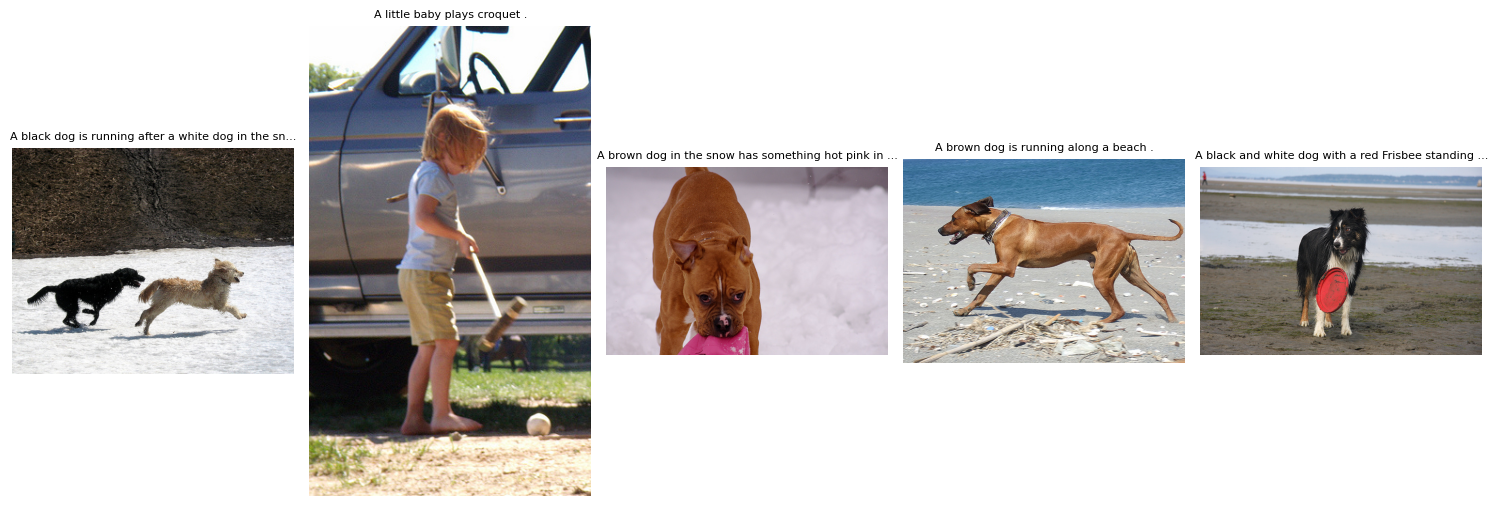


Dataset prepared and ready for training!


In [ ]:
# Load Flickr8k dataset from Hugging Face
print("Loading Flickr8k dataset from Hugging Face...")
print("This may take a few minutes on first run as it downloads the dataset...")

try:
    ds = load_dataset("jxie/flickr8k")
    print(f"Dataset loaded successfully!")
    print(f"Available splits: {list(ds.keys())}")
    print(f"Train split size: {len(ds['train'])}")
    if 'validation' in ds:
        print(f"Validation split size: {len(ds['validation'])}")
    if 'test' in ds:
        print(f"Test split size: {len(ds['test'])}")

    # Display a few examples
    print("\nDisplaying sample images from the dataset...")
    n_display = 5
    examples = ds["train"].select(list(range(min(n_display, len(ds["train"])))))

    plt.figure(figsize=(15, 10))
    for i, ex in enumerate(examples):
        img = ex["image"]  # PIL Image object
        # Get the first caption (caption_0)
        caption = ex.get("caption_0", ex.get("caption", "No caption"))

        plt.subplot(1, n_display, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(caption[:50] + "..." if len(caption) > 50 else caption, fontsize=8)
    plt.tight_layout()
    plt.show()

    print("\nDataset prepared and ready for training!")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Make sure you have internet connection for first-time download.")
    raise


## 6. Training the Model


In [ ]:
# Note: We use the custom collate_fn defined earlier, not DataCollatorWithPadding
# The custom collate_fn properly handles string fields (caption, image_id) along with tensors

Loaded 6000 examples from train split
Created dataloader with batch size 4
Number of batches per epoch: 1500

Starting training...


Epoch 1/3: 100%|██████████| 1500/1500 [17:43<00:00,  1.41it/s, loss=1.95]


Epoch 1/3 - Average Loss: 1.7918


Epoch 2/3: 100%|██████████| 1500/1500 [17:45<00:00,  1.41it/s, loss=0.943]


Epoch 2/3 - Average Loss: 1.2295


Epoch 3/3: 100%|██████████| 1500/1500 [17:46<00:00,  1.41it/s, loss=1.08]

Epoch 3/3 - Average Loss: 0.9346


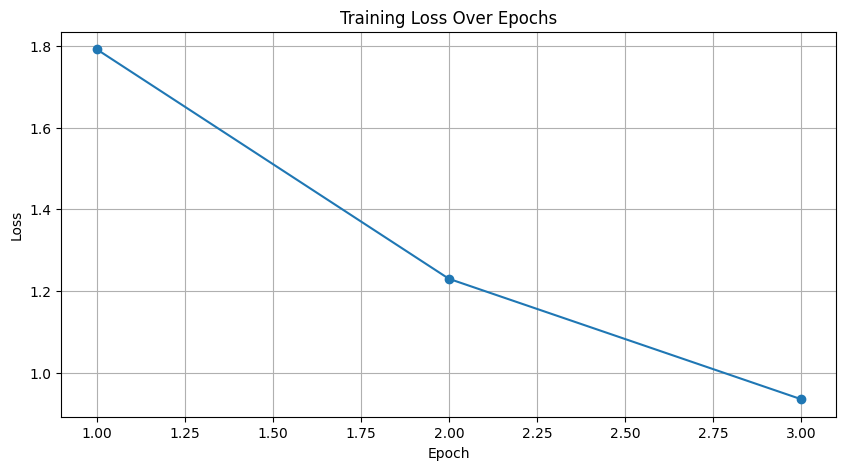

Training completed!


In [ ]:
# Create dataset and dataloader using Flickr8k from Hugging Face
# Make sure 'ds' is defined from the previous cell
if 'ds' not in locals():
    print("Error: Dataset 'ds' not found. Please run the previous cell to load the dataset.")
else:
    # Create training dataset
    train_dataset = Flickr8kDataset(
        hf_dataset=ds,
        processor=processor,
        max_length=50,
        split='train'
    )

    if len(train_dataset) > 0:
        # Create dataloader with appropriate batch size
        # Use smaller batch size if you have memory constraints
        batch_size = 4  # Adjust based on your GPU/CPU memory
        dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0  # Set to 0 to avoid multiprocessing issues in notebooks
        )

        print(f"Created dataloader with batch size {batch_size}")
        print(f"Number of batches per epoch: {len(dataloader)}")

        # Setup optimizer
        optimizer = optim.AdamW(model.parameters(), lr=5e-5)

        # Train model
        print("\nStarting training...")
        num_epochs = 3
        train_losses = train_model(model, dataloader, optimizer, device, num_epochs=num_epochs)

        # Plot training loss
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.grid(True)
        plt.show()

        print("Training completed!")
    else:
        print("Dataset is empty. Using pre-trained model for inference only.")


## 7. Model Evaluation - Calculate Accuracy and Precision


Loaded 1000 examples from validation split
Evaluating model on validation split (1000 examples)...


Evaluating:   5%|▌         | 50/1000 [00:28<09:03,  1.75it/s]



EVALUATION RESULTS (VALIDATION SPLIT)
Average BLEU Score (Accuracy): 0.0807
Average Precision: 0.4696
BLEU Score Range: 0.0120 - 0.3656
Precision Range: 0.0833 - 1.0000


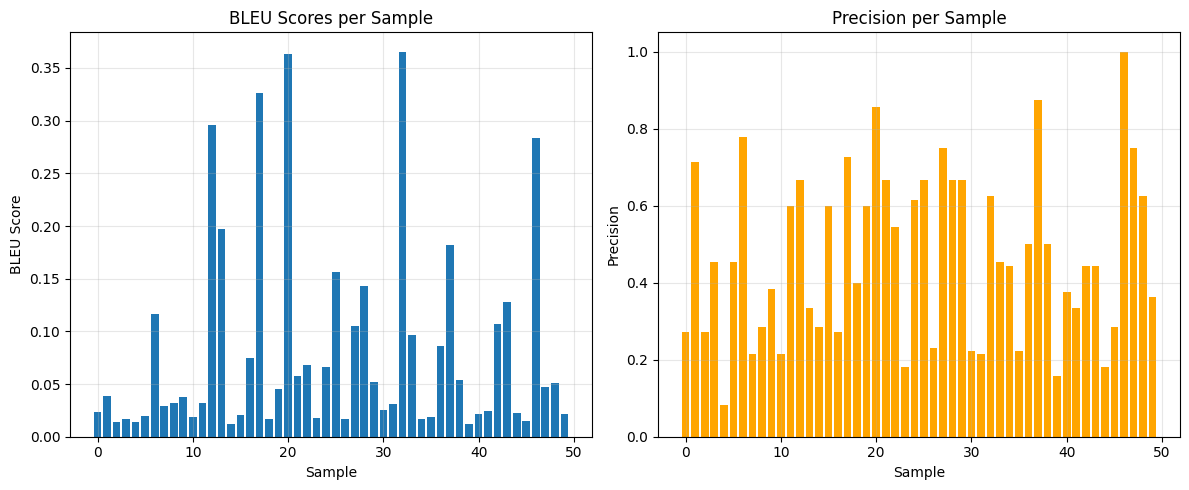

In [ ]:
# Evaluate model
# Use validation split if available, otherwise use a subset of training data
if 'ds' in locals():
    # Try to use validation split, otherwise use test split, otherwise use train
    if 'validation' in ds:
        eval_split = 'validation'
    elif 'test' in ds:
        eval_split = 'test'
    else:
        eval_split = 'train'

    eval_dataset = Flickr8kDataset(
        hf_dataset=ds,
        processor=processor,
        max_length=50,
        split=eval_split
    )

    if len(eval_dataset) > 0:
        eval_dataloader = DataLoader(
            eval_dataset,
            batch_size=1,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0
        )

        print(f"Evaluating model on {eval_split} split ({len(eval_dataset)} examples)...")
        num_eval_samples = min(50, len(eval_dataset))  # Evaluate on up to 50 samples
        avg_bleu, avg_precision, bleu_scores, precisions = evaluate_model(
            model, eval_dataloader, processor, device, num_samples=num_eval_samples
        )

        print(f"\n{'='*50}")
        print(f"EVALUATION RESULTS ({eval_split.upper()} SPLIT)")
        print(f"{'='*50}")
        print(f"Average BLEU Score (Accuracy): {avg_bleu:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"BLEU Score Range: {min(bleu_scores):.4f} - {max(bleu_scores):.4f}")
        print(f"Precision Range: {min(precisions):.4f} - {max(precisions):.4f}")
        print(f"{'='*50}")

        # Plot metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.bar(range(len(bleu_scores)), bleu_scores)
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('BLEU Score')
        ax1.set_title('BLEU Scores per Sample')
        ax1.grid(True, alpha=0.3)

        ax2.bar(range(len(precisions)), precisions, color='orange')
        ax2.set_xlabel('Sample')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision per Sample')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("No dataset available for evaluation. Model is ready for inference.")
else:
    print("No dataset available for evaluation. Please load the dataset first.")


## 8. Image Upload and Caption Generation


In [ ]:
def generate_both_captions(image_path_or_url, transformer_model, processor, cnn_rnn_model, vocab, device, use_yolo=False, beam_size=None):
    """Generate both Transformer and CNN-RNN captions for the same image."""
    try:
        # Load image
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url, timeout=10)
            image_pil = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image_pil = Image.open(image_path_or_url).convert('RGB')

        # Generate Transformer caption
        transformer_caption = None
        if transformer_model is not None and processor is not None:
            transformer_caption = generate_transformer_caption_from_pil(image_pil, transformer_model, processor, device)

        # Generate CNN-RNN caption
        cnn_rnn_caption = None
        if cnn_rnn_model is not None and vocab is not None:
            _, cnn_rnn_caption = generate_cnn_rnn_caption(
                image_path_or_url, cnn_rnn_model, vocab, device, use_yolo=use_yolo, beam_size=beam_size
            )

        return image_pil, transformer_caption, cnn_rnn_caption
    except Exception as e:
        import traceback
        return None, None, f"Error: {str(e)}\n{traceback.format_exc()}"

# Interactive image upload widget with dual caption generation and word suggestions
if IPYWIDGETS_AVAILABLE:
    from ipywidgets import Textarea, VBox, Label, HTML as HTMLWidget

    upload_widget = FileUpload(
        accept='image/*',
        multiple=False,
        description='Upload Image'
    )

    # Create comment box and suggestion label (will be shown after image upload)
    comment_box = Textarea(
        value="",
        placeholder="Write your own caption based on the image...",
        description="Your caption:",
        layout={"width": "100%", "height": "100px"},
        style={'description_width': 'initial'}
    )
    suggestion_label = Label(
        value="Suggestions will appear here after you start typing...",
        layout={"width": "100%"}
    )

    # Container for captions and comment box
    caption_output = Output()
    comment_output = Output()  # Separate output for comment box
    comment_container = VBox([comment_box, suggestion_label])

    def on_comment_change(change):
        """Update recommendations as user types"""
        text = change['new']
        global _last_uploaded_image, _last_cnn_caption, _last_transformer_caption, _last_yolo_objects
        suggestions = get_image_based_recommendations(
            text,
            image_pil=_last_uploaded_image,
            cnn_caption=_last_cnn_caption,
            transformer_caption=_last_transformer_caption,
            yolo_objects=_last_yolo_objects,
            vocab=vocab if 'vocab' in globals() else None
        )
        if suggestions:
            suggestion_label.value = "💡 Suggestions: " + ", ".join(suggestions)
        else:
            suggestion_label.value = "💡 Suggestions: (type to see recommendations)"

    comment_box.observe(on_comment_change, names='value')

    def on_upload_change(change):
        """Handle image upload and generate both captions"""
        global _last_uploaded_image, _last_cnn_caption, _last_transformer_caption, _last_yolo_objects

        with caption_output:
            caption_output.clear_output()

            if len(upload_widget.value) > 0:
                try:
                    # Handle different ipywidgets versions
                    if isinstance(upload_widget.value, dict):
                        uploaded_file = list(upload_widget.value.values())[0]
                    elif isinstance(upload_widget.value, (list, tuple)):
                        uploaded_file = upload_widget.value[0]
                    else:
                        uploaded_file = upload_widget.value

                    # Extract content
                    if isinstance(uploaded_file, dict):
                        file_content = uploaded_file.get('content', uploaded_file.get('data', None))
                    else:
                        file_content = uploaded_file

                    if file_content is None:
                        print("Error: Could not extract file content")
                        return

                    # Save uploaded image temporarily
                    with open('temp_uploaded_image.jpg', 'wb') as f:
                        if isinstance(file_content, bytes):
                            f.write(file_content)
                        else:
                            f.write(file_content.encode() if isinstance(file_content, str) else bytes(file_content))

                    print("🔄 Processing image and generating captions...")

                    # Check if models are defined
                    transformer_model_available = 'model' in globals() and model is not None and 'processor' in globals() and processor is not None
                    cnn_rnn_model_available = 'cnn_rnn_model' in globals() and cnn_rnn_model is not None and 'vocab' in globals() and vocab is not None

                    if not transformer_model_available and not cnn_rnn_model_available:
                        print("Error: No models available. Please run the model loading/training cells first.")
                        return

                    # Load image for YOLO detection
                    image_pil = Image.open('temp_uploaded_image.jpg').convert('RGB')
                    _last_uploaded_image = image_pil

                    # Detect objects with YOLO
                    yolo_objects = []
                    if 'yolo_detector' in globals() and yolo_detector.model is not None:
                        try:
                            yolo_objects = yolo_detector.detect_objects(image_pil)
                            _last_yolo_objects = yolo_objects
                        except:
                            _last_yolo_objects = []
                    else:
                        _last_yolo_objects = []

                    # Generate both captions
                    image, transformer_caption, cnn_rnn_caption = generate_both_captions(
                        'temp_uploaded_image.jpg',
                        model if transformer_model_available else None,
                        processor if transformer_model_available else None,
                        cnn_rnn_model if cnn_rnn_model_available else None,
                        vocab if cnn_rnn_model_available else None,
                        device,
                        use_yolo=True,
                        beam_size=None
                    )

                    if image:
                        # Store for recommendations
                        _last_transformer_caption = transformer_caption
                        _last_cnn_caption = cnn_rnn_caption

                        # Display image and both captions
                        plt.figure(figsize=(12, 8))
                        plt.imshow(image)
                        plt.axis('off')
                        caption_lines = []
                        if transformer_caption:
                            caption_lines.append(f"Transformer: {transformer_caption}")
                        if cnn_rnn_caption:
                            caption_lines.append(f"CNN-RNN: {cnn_rnn_caption}")
                        if not caption_lines:
                            caption_lines.append("No captions generated")
                        plt.title("\n\n".join(caption_lines), fontsize=14, pad=20)
                        plt.tight_layout()
                        plt.show()

                        print(f"\n{'='*70}")
                        if transformer_caption:
                            print(f"📝 TRANSFORMER CAPTION: {transformer_caption}")
                        if cnn_rnn_caption:
                            print(f"📝 CNN-RNN CAPTION   : {cnn_rnn_caption}")
                        if yolo_objects:
                            print(f"🔍 Detected objects: {', '.join(yolo_objects[:5])}")
                        print(f"{'='*70}\n")

                        # Show comment box after captions are generated
                        comment_box.value = ""  # Clear previous text
                        with comment_output:
                            comment_output.clear_output()
                            display(HTMLWidget("<h4>✍️ Write your own caption (with smart suggestions):</h4>"))
                            display(comment_container)
                    else:
                        print(f"Error: {cnn_rnn_caption or transformer_caption}")
                except Exception as e:
                    print(f"Error processing uploaded file: {e}")
                    import traceback
                    traceback.print_exc()

    upload_widget.observe(on_upload_change, names='value')

    display(HTML("<h3>📤 Upload an image to generate captions:</h3>"))
    display(upload_widget)
    display(caption_output)
    display(comment_output)  # Display comment box area (will be populated after upload)
else:
    display(HTML("<h3>Image Upload Widget</h3>"))
    display(HTML("<p>ipywidgets is not available. Please use the <code>caption_image()</code> function instead.</p>"))
    display(HTML("<p>To enable the upload widget, install: <code>pip install ipywidgets jupyter</code> and restart the kernel.</p>"))


FileUpload(value={}, accept='image/*', description='Upload Image')

Output()

Output()